# Baseline Komorebi

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [168]:
root_folder = "/Users/alvaroleal/Desktop/DS/komorebi"

df= pd.read_parquet(root_folder + '/muestreos_parcelas_2023.parquet')

### Preparamos el dataset
 - Limpiamos los datos con los resultados del EDAs
 - Unificamos los estados fenológicos en una sola columna
 - Creamos el y

In [169]:
def clean_df(df):
    """
    Función para realizar todo el lipiado de datos, en este momento elimina las filas del DataFrame donde el año es 2005, 2021 o 2022.

    Args:
    df(pd.DataFrame): DataFrame original.

    Returns:
    pd.DataFrame: DataFrame limpiado.
    """
    # Añadimos los resultados del EDAs
    df = df.drop('generated_muestreos', axis=1)
    cols = ['fecha'] + [col for col in df if col != 'fecha']
    df = df[cols]
    df['fecha'] = df['fecha'].astype('datetime64[ns]')
    df = df[~df['fecha'].dt.year.isin([2003, 2005])]
    
    return df

In [170]:
def unificar_estados(df: pd.DataFrame) -> pd.DataFrame:
    columnas_estados = [f'estado_fenologico_{i}' for i in range(14, 0, -1)]
    
    df['estado_fenologico_unificado'] = df.apply(
        lambda row: next((col.split('_')[-1] for col in columnas_estados if row[col] == 2), pd.NA), axis=1)
    df['estado_fenologico_unificado'] = pd.to_numeric(df['estado_fenologico_unificado'], errors='coerce')
    
    # Columnas simplificadas para calcular el baseline
    df= df[['codparcela', 'fecha', 'estado_fenologico_unificado']]
    
    return df


In [171]:
def generate_y(df: pd.DataFrame, window_size: int = 14, window_tolerance: int = 2) -> pd.DataFrame:
    # Crear una copia para trabajar sin modificar el DataFrame original
    df_copy = df.copy()

    # Generar fecha futura para buscar el estado fenológico en el futuro
    df_copy['fecha_futuro'] = df_copy['fecha'] + pd.Timedelta(days=window_size)

    # Realizar una fusión asof para encontrar correspondencias dentro de una ventana de tiempo específica
    df_with_y = pd.merge_asof(
        df_copy.sort_values('fecha'), df_copy.sort_values('fecha'), 
        by='codparcela', left_on='fecha_futuro', right_on='fecha', 
        suffixes=('', '_future'), direction='nearest', tolerance=pd.Timedelta(days=window_tolerance)
    )

    # Generar la columna objetivo - Número de estados fenológicos que pasaron en el tamaño de ventana elegido
    df_with_y['y'] = df_with_y['estado_fenologico_unificado_future'] - df_with_y['estado_fenologico_unificado']

    # Eliminar todas las filas con valor nulo en la columna objetivo
    df_with_y = df_with_y[df_with_y['y'].notnull()]

    # Establecer a 0 cuando la columna objetivo sea negativa
    df_with_y.loc[df_with_y['y'] < 0, 'y'] = 0

    df_with_y=  df_with_y[['codparcela', 'fecha', 'estado_fenologico_unificado','y']]
     

    return df_with_y

In [172]:
df= clean_df(df)
df= unificar_estados(df)
df= generate_y(df)
df

,codparcela,fecha,estado_fenologico_unificado,y
15,001-00004-00-00,2006-03-01,2.0,0.0
22,033-00381-00-00,2006-03-06,1.0,0.0
25,005-00042-00-00,2006-03-06,1.0,1.0
28,030-00675-00-00,2006-03-06,1.0,0.0
31,022-00304-00-00,2006-03-06,1.0,0.0
...,...,...,...,...
677070,017-00008-01-01,2023-09-21,10.0,1.0
677071,009-00006-02,2023-09-21,10.0,1.0
677073,011-00060-01-01,2023-09-22,10.0,1.0
677075,011-00088-01-01,2023-09-22,10.0,0.0


## Baseline predict:
- Train/Test Split: Dividimos nuestro dataset por cosechas utilizando 2018 como el punto de inversión.
- Calculamos la media ponderada agrupando por año y estado fenológico, convertimos ese dataframe a un diccionario el cual luego usamos para mapear el conjunto de test y realizar las predicciones.
- Redondeamos nuestras predicciones para poder evaluar el modelo.
- Utilizamos accuracy como métrica de evaluación del modelo obteniendo un 76% de aciertos.

In [173]:
# Dividimos nuestras muestras por años - Tenemos que ver si incluimos también un set de validación
df['year'] = df['fecha'].dt.year

train = df[df['year'] <= 2021].copy()
test = df[df['year'] > 2021].copy()

In [174]:
max_year = train['year'].max()
train['weight'] = train['year'].apply(lambda x: 0.1 ** (max_year - x))

# Agrupamos por estado fenológico y año, y calcular la media ponderada
grouped = train.groupby(['estado_fenologico_unificado', 'year'])
weighted_means = grouped.apply(lambda x: (x['y'] * x['weight']).sum() / x['weight'].sum()).reset_index()
weighted_means.rename(columns={0: 'weighted_mean'}, inplace=True)

# Convertimos este DataFrame en un diccionario donde la clave es el estado y el valor es la media ponderada más reciente
mapeo_referencia = weighted_means.sort_values('year', ascending=False).drop_duplicates('estado_fenologico_unificado').set_index('estado_fenologico_unificado')['weighted_mean'].to_dict()

# Aplicamos el mapeo de referencia al conjunto de test para obtener las predicciones
test['y_pred'] = test['estado_fenologico_unificado'].map(mapeo_referencia)

# Redondeamos las predicciones ya que la métrica de precisión requiere valores discretos
test['y_pred_rounded'] = test['y_pred'].round()

In [175]:
# Eliminamos filas con NaN en 'y' antes de calcular la precisión.
mask = test['y'].notna()
test_filtered = test[mask]

# Ahora, calculamos la precisión solo en las filas sin NaN.
accuracy = accuracy_score(test_filtered['y'], test_filtered['y_pred_rounded'])
print(f"Baseline Model Accuracy: {accuracy}")

Baseline Model Accuracy: 0.6643918347626525


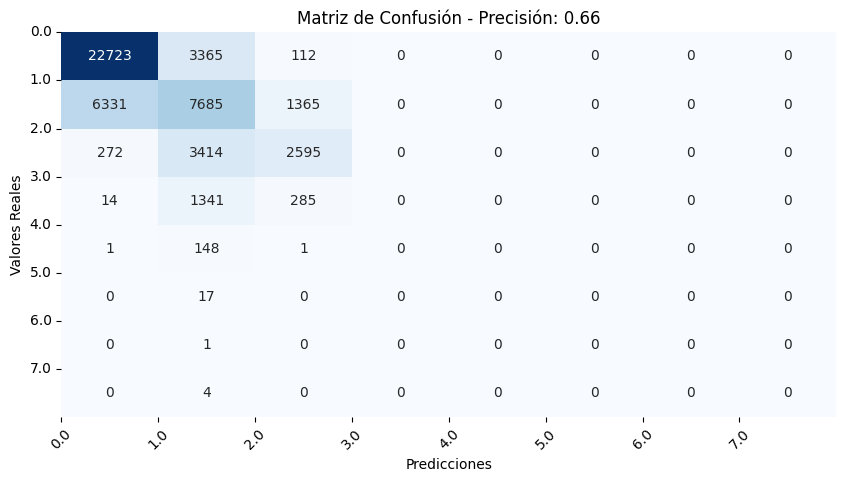

In [176]:
cm = confusion_matrix(test_filtered['y'], test_filtered['y_pred_rounded'])

accuracy = accuracy_score(test_filtered['y'], test_filtered['y_pred_rounded'])

plt.figure(figsize=(10, 5))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=True, yticklabels=True) 

plt.title(f'Matriz de Confusión - Precisión: {accuracy:.2f}')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')

unique_classes = sorted(test_filtered['y'].unique())
plt.xticks(ticks=range(len(unique_classes)), labels=unique_classes, rotation=45) 
plt.yticks(ticks=range(len(unique_classes)), labels=unique_classes, rotation=0)

plt.show()

## Conclusiones:

Acercamiento muy sencillo a lo que podría suponer un punto de partida para tratar de hacer modelos más complejos, cual feedback es bienvenido :)

*Cálculo del Baseline:*

- Calculamos un modelo muy sencillo definiendo el y como elnúmero de estados fenológicos que había pasado una muestra con respecto a su instancia anterior. Se corrigieron los avances fenológicos negativos resultantes de errores en el muestreo y se excluyeron las instancias iniciales y finales de cada año para evitar inconsistencias entre diferentes cosechas.

*Predicción del Baseline:*

- Implementamos una división del dataset por cosechas, utilizando el año 2018 como punto de corte. Esto permitió que las fases de prueba y entrenamiento reflejen las condiciones más actuales sin mezclar datos de cosechas anteriores.
Se empleó una media ponderada para cada combinación de año y estado fenológico, convirtiendo luego este dataframe en un diccionario que fue utilizado para mapear y realizar predicciones en el conjunto de test. Nota: Podemos probar con otros criterios estadísticos con la mediana para ver cómo cambia la métrica de evaluación.

*Evaluación del Baseline:*

- Las predicciones fueron ajustadas mediante redondeo para facilitar la evaluación con la métrica de precisión. El modelo alcanzó una precisión inicial del 76%.
